In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import torch
from typing import List
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import spacy
from bs4 import BeautifulSoup

import keras_hub

2025-04-26 10:31:02.115774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745663462.280084      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745663462.325589      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Utility functions

In [3]:
# Stopword List : https://github.com/6/stopwords-json/blob/master/dist/en.json
from nltk.corpus import stopwords
sw1 = ["a","a's","able","about","above","according","http","https","accordingly","across","actually","after","afterwards","again","against","ain't","all","allow","allows","almost","alone","along","already","also","although","always","am","among","amongst","an","and","another","any","anybody","anyhow","anyone","anything","anyway","anyways","anywhere","apart","appear","appreciate","appropriate","are","aren't","around","as","aside","ask","asking","associated","at","available","away","awfully","b","be","became","because","become","becomes","becoming","been","before","beforehand","behind","being","believe","below","beside","besides","best","better","between","beyond","both","brief","but","by","c","c'mon","c's","came","can","can't","cannot","cant","cause","causes","certain","certainly","changes","clearly","co","com","come","comes","concerning","consequently","consider","considering","contain","containing","contains","corresponding","could","couldn't","course","currently","d","definitely","described","despite","did","didn't","different","do","does","doesn't","doing","don't","done","down","downwards","during","e","each","edu","eg","eight","either","else","elsewhere","enough","entirely","especially","et","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","exactly","example","except","f","far","few","fifth","first","five","followed","following","follows","for","former","formerly","forth","four","from","further","furthermore","g","get","gets","getting","given","gives","go","goes","going","gone","got","gotten","greetings","h","had","hadn't","happens","hardly","has","hasn't","have","haven't","having","he","he's","hello","help","hence","her","here","here's","hereafter","hereby","herein","hereupon","hers","herself","hi","him","himself","his","hither","hopefully","how","howbeit","however","i","i'd","i'll","i'm","i've","ie","if","ignored","immediate","in","inasmuch","inc","indeed","indicate","indicated","indicates","inner","insofar","instead","into","inward","is","isn't","it","it'd","it'll","it's","its","itself","j","just","k","keep","keeps","kept","know","known","knows","l","last","lately","later","latter","latterly","least","less","lest","let","let's","like","liked","likely","little","look","looking","looks","ltd","m","mainly","many","may","maybe","me","mean","meanwhile","merely","might","more","moreover","most","mostly","much","must","my","myself","n","name","namely","nd","near","nearly","necessary","need","needs","neither","never","nevertheless","new","next","nine","no","nobody","non","none","noone","nor","normally","not","nothing","novel","now","nowhere","o","obviously","of","off","often","oh","ok","okay","old","on","once","one","ones","only","onto","or","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","own","p","particular","particularly","per","perhaps","placed","please","plus","possible","presumably","probably","provides","q","que","quite","qv","r","rather","rd","re","really","reasonably","regarding","regardless","regards","relatively","respectively","right","s","said","same","saw","say","saying","says","second","secondly","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sensible","sent","serious","seriously","seven","several","shall","she","should","shouldn't","since","six","so","some","somebody","somehow","someone","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specified","specify","specifying","still","sub","such","sup","sure","t","t's","take","taken","tell","tends","th","than","thank","thanks","thanx","that","that's","thats","the","their","theirs","them","themselves","then","thence","there","there's","thereafter","thereby","therefore","therein","theres","thereupon","these","they","they'd","they'll","they're","they've","think","third","this","thorough","thoroughly","those","though","three","through","throughout","thru","thus","to","together","too","took","toward","towards","tried","tries","truly","try","trying","twice","two","u","un","under","unfortunately","unless","unlikely","until","unto","up","upon","us","use","used","useful","uses","using","usually","uucp","v","value","various","very","via","viz","vs","w","want","wants","was","wasn't","way","we","we'd","we'll","we're","we've","welcome","well","went","were","weren't","what","what's","whatever","when","whence","whenever","where","where's","whereafter","whereas","whereby","wherein","whereupon","wherever","whether","which","while","whither","who","who's","whoever","whole","whom","whose","why","will","willing","wish","with","within","without","won't","wonder","would","wouldn't","x","y","yes","yet","you","you'd","you'll","you're","you've","your","yours","yourself","yourselves","z","zero"]
sw1 = set(sw1)
sw = stopwords.words("english")
sw = set(sw)
STOPWORDS = set.union(sw1, sw)

In [4]:
def remove_punctuation(text):
    import string
# replacing the punctuations with no space,
# which in effect deletes the punctuation marks
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

In [5]:
def remove_stopwords(text):
# filter out words that are in the stopword list
# also lowercasing text entries
    text = [x.lower() for x in text.split() if x.lower() not in STOPWORDS]
# text is a collection of non-stopwords (in lowercase)
# now join the words with space separator and return them as a string
    return " ".join(text)

In [6]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [7]:
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

In [8]:
def remove_URLs(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Loading the data:

In [9]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [10]:
train["text"] = train["text"].apply(remove_punctuation)
test["text"] = test["text"].apply(remove_punctuation)

In [11]:
train['text'] = train['text'].apply(remove_stopwords)
test['text'] = test['text'].apply(remove_stopwords)

In [12]:
train['text'] = train['text'].apply(remove_emojis)
test['text'] = test['text'].apply(remove_emojis)

In [13]:
train['text'] = train['text'].apply(remove_html)
test['text'] = test['text'].apply(remove_html)

In [14]:
train['text'] = train['text'].apply(remove_URLs)
test['text'] = test['text'].apply(remove_URLs)

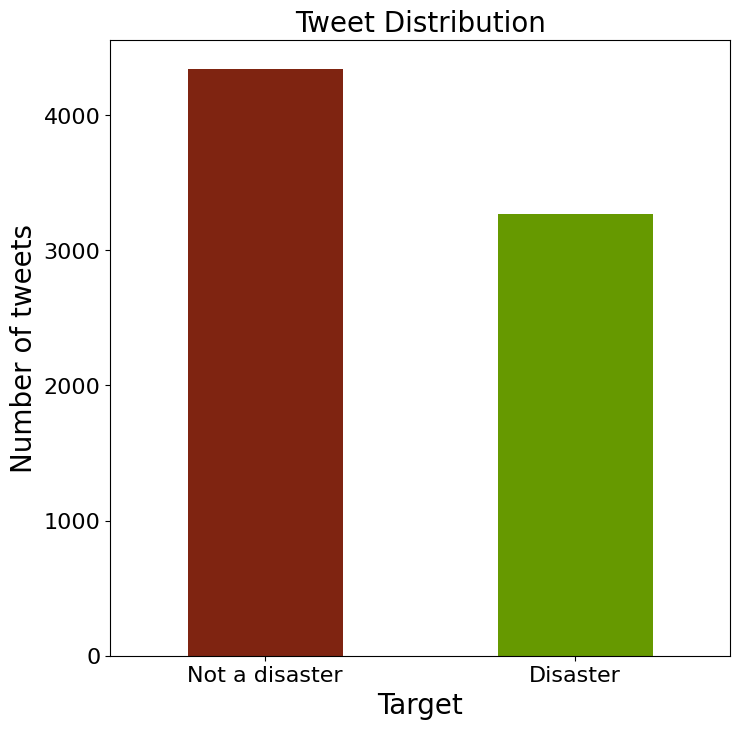

In [15]:
#Visualize the data
fig, ax = plt.subplots(figsize=(8,8))
train['target'].value_counts(sort=True).plot(kind='bar', color={'#7F2411','#669900'}, fontsize = 16)
x = ['Not a disaster', 'Disaster']
default_x_ticks = range(len(x))
plt.xticks(default_x_ticks, x, rotation=0, fontsize = 16)
plt.title('Tweet Distribution', fontsize = 20)
plt.xlabel('Target', fontsize = 20)
plt.ylabel('Number of tweets', fontsize = 20)
plt.show()

In [16]:
train['target'].value_counts(sort=True)

target
0    4342
1    3271
Name: count, dtype: int64

In [17]:
pp_train = train.copy()

In [18]:
# Get TF-IDF ranking of words to fill in our `keyword` and `location` datapoints

# Preprocess our text setup
nlp = spacy.load('en_core_web_sm')

def preprocess(txt):
    doc = nlp(txt.lower())
    return ' '.join([token.lemma_ for token in doc if token.is_alpha and not token.is_stop]) # remove stopwords and lemmatize them!

pp_train['text'] = train['text'].apply(preprocess)

pp_train['text']

0                    deed reason earthquake allah forgive
1                        forest fire la ronge sask canada
2       resident ask shelter place notify officer evac...
3       people receive wildfire evacuation order calif...
4            photo ruby alaska smoke wildfire pour school
                              ...                        
7608         giant crane hold bridge collapse nearby home
7609    ariaahrary thetawniest control wild fire calif...
7610                                    km volcano hawaii
7611    police investigate ebike collide car portugal ...
7612    late home raze northern california wildfire ab...
Name: text, Length: 7613, dtype: object

# Preprosessing

In [19]:
# get website

def get_keywords(topic: str) -> List:
    related_words = []
    link = f'https://relatedwords.io/{topic}'

    try:
        response = requests.get(link, timeout=5)
        response.raise_for_status()
    except requests.Timeout:
        print(f'Timeout Error: {e}')
    except requests.RequestException as e:
        print(f'Request failed: {e}')

    # use soup to extract all words!
    soup = BeautifulSoup(response.content, 'html.parser')

    for a in soup.find_all('a'):
        word = a.text.strip().lower()
        if word.isalpha():
            related_words.append(word)

    return [preprocess(word) for word in related_words]


topics = ['disaster', 'terrorism', 'war']
keywords = []

for topic in topics:
    keywords.extend(get_keywords(topic))

keywords = {word for word in keywords if word}

print(sorted(list(keywords))[:40])
print('Size:', len(keywords))

['abb', 'abuse', 'abusive', 'accident', 'accuse', 'act', 'action', 'active', 'activity', 'adventure', 'adversity', 'affect', 'afflict', 'affliction', 'afghanistan', 'aftermath', 'agency', 'agenda', 'aggravation', 'aggression', 'ago', 'aiai', 'aid', 'ail', 'aim', 'algeria', 'alien', 'alir', 'allege', 'ally', 'annihilation', 'ano', 'ant', 'antagonism', 'anti', 'antisemitism', 'antiterrorism', 'antiterrorist', 'antiwar', 'aphorism']
Size: 952


In [20]:
# TF-IDF
vector = TfidfVectorizer()
X = vector.fit_transform(pp_train['text'])
vocab = vector.get_feature_names_out()

loc_words = set()
docs = list(nlp.pipe([f'I am in {w}' for w in vocab]))
for word, doc in zip(vocab, docs):
    if any(ent.label_ == 'GPE' for ent in doc.ents):
        loc_words.add(word)

def get_key(text, r_idx, loc=False):
    og_tokens = set(text.iloc[r_idx].split())
    row = X[r_idx].toarray()[0]
    sorted_idx = row.argsort()[::-1] # take largest
    for idx in sorted_idx:
        can = vocab[idx]
        if not loc and can in keywords and can in og_tokens: # if we want keyword
            return can
        elif loc and can in loc_words and can in og_tokens: # if we want location
            return can
    return 'No Keyword'

pp_train['keyword'] = [get_key(pp_train['text'], i) for i in range(len(pp_train))]
pp_train['location'] = [get_key(pp_train['text'], i, True) for i in range(len(pp_train))]

In [21]:
pp_train

,id,keyword,location,text,target
0,1,earthquake,No Keyword,deed reason earthquake allah forgive,1
1,4,fire,canada,forest fire la ronge sask canada,1
2,5,expect,No Keyword,resident ask shelter place notify officer evac...,1
3,6,evacuation,california,people receive wildfire evacuation order calif...,1
4,7,school,alaska,photo ruby alaska smoke wildfire pour school,1
...,...,...,...,...,...
7608,10869,collapse,No Keyword,giant crane hold bridge collapse nearby home,1
7609,10870,state,california,ariaahrary thetawniest control wild fire calif...,1
7610,10871,volcano,No Keyword,km volcano hawaii,1
7611,10872,threaten,portugal,police investigate ebike collide car portugal ...,1


# BERT Setup

In [22]:
preprocessor = keras_hub.models.DistilBertPreprocessor.from_preset('distil_bert_base_en_uncased', 
                                                                   sequence_length=128)

classifier = keras_hub.models.DistilBertClassifier.from_preset('distil_bert_base_en_uncased', 
                                                               num_classes=1,
                                                               preprocessor=preprocessor)

classifier.compile(loss=BinaryCrossentropy(from_logits=True), optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

classifier.summary()

I0000 00:00:1745663580.155364      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Preprocessor: "distil_bert_text_classifier_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 1)                 │             769 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,954,241 (255.41 MB)

 Trainable params: 66,954,241 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

# Build BERT model

In [23]:
combined_text = ('keyword: ' + pp_train['keyword'] + 
                 ' location: ' + pp_train['location'] + 
                 ' text: ' + pp_train['text'])

# resplit data, this time with our combined text
X_temp, X_test, y_temp, y_test = train_test_split(combined_text, pp_train['target'], test_size=0.2, stratify=pp_train['target'])
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1675, stratify=y_temp)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

final = classifier.fit(x=X_train.tolist(), y=y_train.astype('float32').values, 
               validation_data=(X_val.tolist(), y_val.astype('float32').values), 
               batch_size=32, epochs=10, callbacks=[early_stop])

Epoch 1/10


I0000 00:00:1745663612.985018      59 service.cc:148] XLA service 0x7cbb20001930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745663612.985567      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745663615.326332      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745663629.467547      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


159/159 ━━━━━━━━━━━━━━━━━━━━ 95s 342ms/step - accuracy: 0.6455 - loss: 0.6017 - val_accuracy: 0.7992 - val_loss: 0.4559
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 219ms/step - accuracy: 0.8211 - loss: 0.4248 - val_accuracy: 0.8188 - val_loss: 0.4404
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 218ms/step - accuracy: 0.8559 - loss: 0.3598 - val_accuracy: 0.8178 - val_loss: 0.4562
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 217ms/step - accuracy: 0.8762 - loss: 0.3178 - val_accuracy: 0.7992 - val_loss: 0.5136
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 217ms/step - accuracy: 0.8947 - loss: 0.2839 - val_accuracy: 0.7924 - val_loss: 0.5416
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 217ms/step - accuracy: 0.9151 - loss: 0.2464 - val_accuracy: 0.8022 - val_loss: 0.5157
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 35s 222ms/step - accuracy: 0.9210 - loss: 0.2197 - val_accuracy: 0.8110 - val_loss: 0.5201


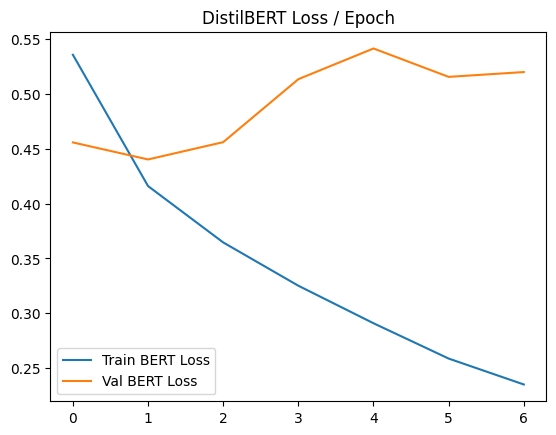

In [24]:
plt.plot(final.history['loss'], label='Train BERT Loss')
plt.plot(final.history['val_loss'], label='Val BERT Loss')
plt.title('DistilBERT Loss / Epoch')
plt.legend()

48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step


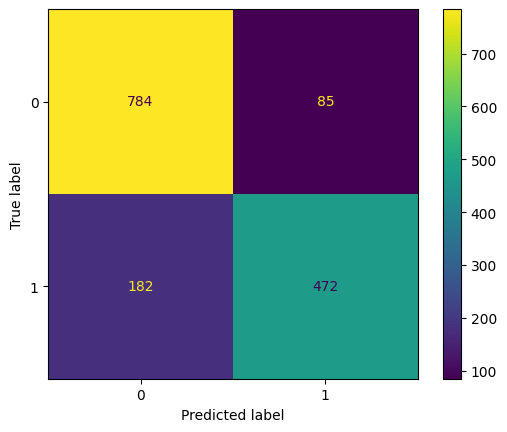

In [25]:
y_pred = classifier.predict(X_test.tolist())
y_pred_lbls = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_lbls)
ConfusionMatrixDisplay(cm).plot()

In [26]:
print(classification_report(y_test, y_pred_lbls))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       869
           1       0.85      0.72      0.78       654

    accuracy                           0.82      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.82      0.82      1523



# Testing

In [27]:
test

,id,keyword,location,text
0,0,NaN,NaN,happened terrible car crash
1,2,NaN,NaN,heard earthquake cities stay safe
2,3,NaN,NaN,forest fire spot pond geese fleeing street save
3,9,NaN,NaN,apocalypse lighting spokane wildfires
4,11,NaN,NaN,typhoon soudelor kills 28 china taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles ûò safety faste...
3259,10865,NaN,NaN,storm ri worse hurricane cityamp3others hardes...
3260,10868,NaN,NaN,green line derailment chicago httptcoutbxlcbiuy
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo httpt...


In [28]:
# preprocess text to get keyword + location
test['text'] = test['text'].apply(preprocess)

# TF-IDF
X = vector.transform(test['text'])
vocab = vector.get_feature_names_out()

loc_words = set()
docs = list(nlp.pipe([f'I am in {w}' for w in vocab]))
for word, doc in zip(vocab, docs):
    if any(ent.label_ == 'GPE' for ent in doc.ents):
        loc_words.add(word)

test['keyword'] = [get_key(test['text'], i) for i in range(len(test))]
test['location'] = [get_key(test['text'], i, True) for i in range(len(test))]

test

,id,keyword,location,text
0,0,terrible,No Keyword,happen terrible car crash
1,2,earthquake,No Keyword,hear earthquake city stay safe
2,3,fire,No Keyword,forest fire spot pond geese flee street save
3,9,apocalypse,No Keyword,apocalypse light spokane wildfire
4,11,typhoon,taiwan,typhoon soudelor kill china taiwan
...,...,...,...,...
3258,10861,earthquake,No Keyword,earthquake safety los angeles safety fastener ...
3259,10865,hard,No Keyword,storm ri bad hurricane hard hit yard bomb power
3260,10868,derailment,chicago,green line derailment chicago httptcoutbxlcbiuy
3261,10874,weather,No Keyword,meg issue hazardous weather outlook hwo


In [29]:
combined_text = ('keyword: ' + test['keyword'] + 
                 ' location: ' + test['location'] + 
                 ' text: ' + test['text'])

submission_bert = (classifier.predict(combined_text) > 0.5).astype(int)

submission_bert_df = pd.DataFrame({
    'id': test['id'],
    'target': submission_bert.flatten()
})

submission_bert_df.to_csv('submission_bert.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step


In [30]:
print(" Successfully completed! ")

 Successfully completed! 


In [31]:
submission_bert_df.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
